# Section D. Ridge Regression
## Question 6 [Ridge Regression, 25 Marks]
### Q6-2 & Q6-3

In [43]:
# Written by Gholamreza Haffari, July 2016
#======
#You are welcome to use this code for your submission if you would like to; otherwise, you are welcome to use your own code that you have developed so far. 

# The main aim is to help you folks to move forward to interesting parts of the Assessment, and to not get stuck in some implementation details of Q1.ˇ
# Particularly, please note (1) the way that SGD and BGD are implemented (they closely match what we saw in the unit's content), and (2) the way that 
# data is ˇstandardised after the raw data is read from the CSV files (you could work with non-standardised data as well but usually researchers/data-scientists 
# standardise the data since then you get better behaviour for the machine learning algorithms applied later on the data; this is in itself a big area that those of 
# you who take the "Data Wrangling" unit will get to see in more details).ˇ

# To adapt this code for Q1, you only need to modify the following two functions: "bgd_update_weight" and "sgd_update_weight" so that they take into account the effect of the L2 regulariser.
#========

# reading the data
read_data <- function(fname, sc) {
  data <- read.csv(file=fname,head=TRUE,sep=",")
  #data <- read.csv('assessments_datasets/Task2A.csv',head=TRUE,sep=",")
  nr = dim(data)[1]
  nc = dim(data)[2]
  x = data[1:nr,1:(nc-1)]
  y = data[1:nr,nc]
  if (isTRUE(sc)) {
    x = scale(x)
    y = scale(y)
  }
  return (list("x" = x, "y" = y))
}

# auxiliary function to calculate labels based on the estimated coefficients
predict_func <- function(Phi, w){
  return(Phi%*%w)
} 

# auxiliary function to calculate the objective function for the training
train_obj_func <- function (Phi, w, label, lambda){
  # the L2 regulariser is already included in the objective function for training 
  return(mean((predict_func(Phi, w) - label)^2) + .5 * lambda * w %*% w)
}

# auxiliary function to compute the error of the model
get_errors <- function(train_data, test_data, W) {
  n_weights = dim(W)[1]
  errors = matrix(,nrow=n_weights, ncol=2)
  for (tau in 1:n_weights) {
    errors[tau,1] = train_obj_func(train_data$x, W[tau,],train_data$y, 0)
    errors[tau,2] = train_obj_func(test_data$x, W[tau,],test_data$y, 0)
  }
  return(errors)
}

##--- Stochastic Gradient Descent --------------------------------------------
sgd_train <- function(train_x, train_y, lambda, eta, epsilon, max_epoch) {
  
  train_len = dim(train_x)[1]
  tau_max = max_epoch * train_len
  
  W <- matrix(,nrow=tau_max, ncol=ncol(train_x)) 
  W[1,] <- runif(ncol(train_x))
  
  tau = 1 # counter 
  obj_func_val <-matrix(,nrow=tau_max, ncol=1) 
  obj_func_val[tau,1] = train_obj_func(train_x, W[tau,],train_y, lambda)
  
  while (tau <= tau_max){
    
    # check termination criteria
    if (obj_func_val[tau,1]<=epsilon) {break}
    
    # shuffle data:
    train_index <- sample(1:train_len, train_len, replace = FALSE)
    
    # loop over each datapoint
    for (i in train_index) {
      # increment the counter
      tau <- tau + 1
      if (tau > tau_max) {break}
      
      # make the weight update
      y_pred <- predict_func(train_x[i,], W[tau-1,])
      W[tau,] <- sgd_update_weight(W[tau-1,], train_x[i,], train_y[i], y_pred, lambda, eta)
      
      # keep track of the objective funtion
      obj_func_val[tau,1] = train_obj_func(train_x, W[tau,],train_y, lambda)
    }
  }
  # resulting values for the training objective function as well as the weights
  return(list('vals'=obj_func_val,'W'=W))
}

# updating the weight vector
sgd_update_weight <- function(W_prev, x, y_true, y_pred, lambda, eta) {
  # L2 REG
  grad = - (y_true-y_pred) * x 
  return(W_prev - eta * (grad+lambda*W_prev))
}

##--- Batch Gradient Descent --------------------------------------------
bgd_train <- function(train_x, train_y, lambda, eta, epsilon, max_epoch) {
  
  train_len = dim(train_x)[1]
  
  W <- matrix(,nrow=(max_epoch+1), ncol=ncol(train_x))
  W[1,] <- runif(ncol(train_x))
  
  tau = 1 # counter 
  obj_func_val <-matrix(,nrow=(max_epoch+1), ncol=1)
  obj_func_val[tau,1] = train_obj_func(train_x, W[tau,],train_y, lambda)
  
  trainin_size = dim(train_x)[1]
  for (tau in 1:max_epoch){
    
    # check termination criteria
    if (obj_func_val[tau,1]<=epsilon) {break}
    
    # make prediction over the training set
    y_pred = train_x %*% W[tau,]
    
    # update the weight you may decide to chose linea search or not (we are not using line search here)
    W[tau+1,] = bgd_update_weight(W[tau,], train_x, train_y, y_pred, lambda, eta)
    
    # keep track of the objective funtion
    obj_func_val[tau+1,1] = train_obj_func(train_x, W[tau+1,],train_y, lambda)
  } 
  # resulting values for the training objective function as well as the weights
  return(list('vals'=obj_func_val,'W'=W))
}

# updating the weight vector
bgd_update_weight <- function(W_prev, x, y_true, y_pred, lambda, eta) {
  # L2 REG
  grad = -colMeans(matrix((y_true-y_pred),nrow=dim(x)[1],ncol=dim(x)[2]) * x)
  return (W_prev - eta * (grad+lambda*W_prev))
}

##------------------------------------------------------------------------
play_with_sgd <- function() {
  ## reading the data
  dtrain = read_data("assessments_datasets/Task2A_train.csv", TRUE)
  dtest = read_data("assessments_datasets/Task2A_test.csv", TRUE)
  
  ##### SGD Trainng
  max_epoch = 20
  epsilon = .001
  eta = .01
  lambda=0
  
  train_res = sgd_train(dtrain$x, dtrain$y, lambda, eta, epsilon, max_epoch)
  errors = get_errors(dtrain, dtest, train_res$W) 
  
  plot(train_res$val, main="SGD", type="l", col="blue", ylim=c(0,.1), xlab="iteration", ylab="training objective function")
  plot(errors[1:17000,1], type="l", col="blue",ylim=c(0,1), xlab="iteration", ylab="error")
  lines(errors[1:17000,2], type="l", lty=2, lwd=2, col="red")
}

play_with_bgd <- function() {
  ## reading the data
  dtrain = read_data("assessments_datasets/Task2A_train.csv", TRUE)
  dtest = read_data("assessments_datasets/Task2A_test.csv", TRUE)
  
  ##### BGD Training
  max_epoch = 20
  epsilon = .001
  eta = .01
  lambda=0
  
  train_res = bgd_train(dtrain$x, dtrain$y, lambda, eta, epsilon, max_epoch)
  errors = get_errors(dtrain, dtest, train_res$W)
  plot(train_res$val, main="BGD", type="l", col="blue", xlab="iteration", ylab="training objective function")
  plot(errors[1:21,1], type="l", col="blue",ylim=c(0,1), xlab="iteration", ylab="error")
  lines(errors[1:21,2], type="l", lty=2, lwd=2, col="red")
}

##############################################################

# playing with the SGD part
#play_with_sgd()

# playing with the BGD part
#play_with_bgd()

options(warn = -1)

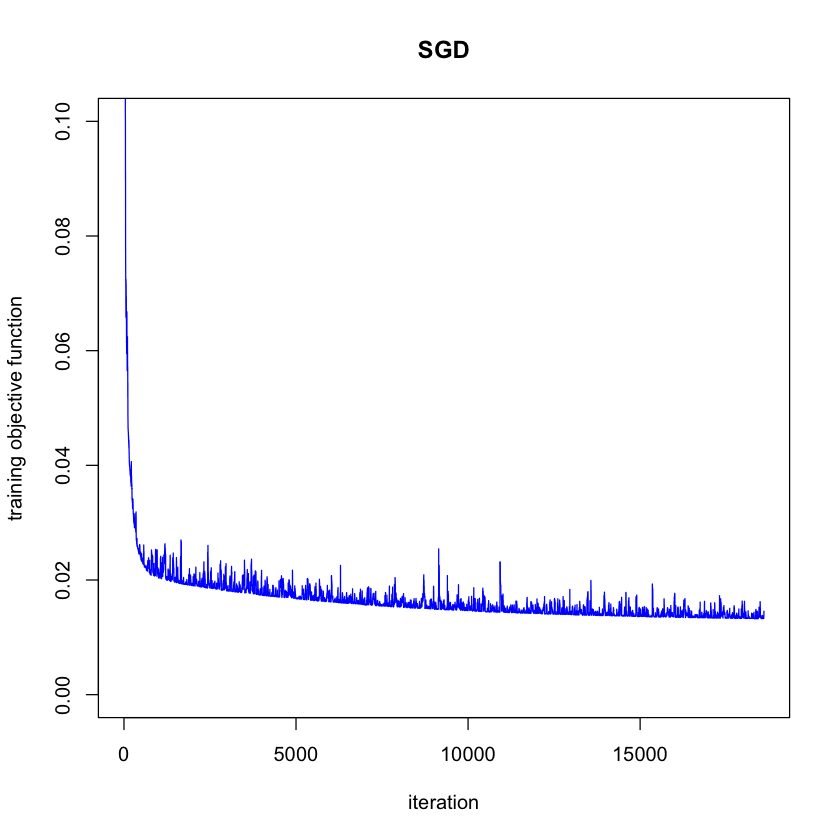

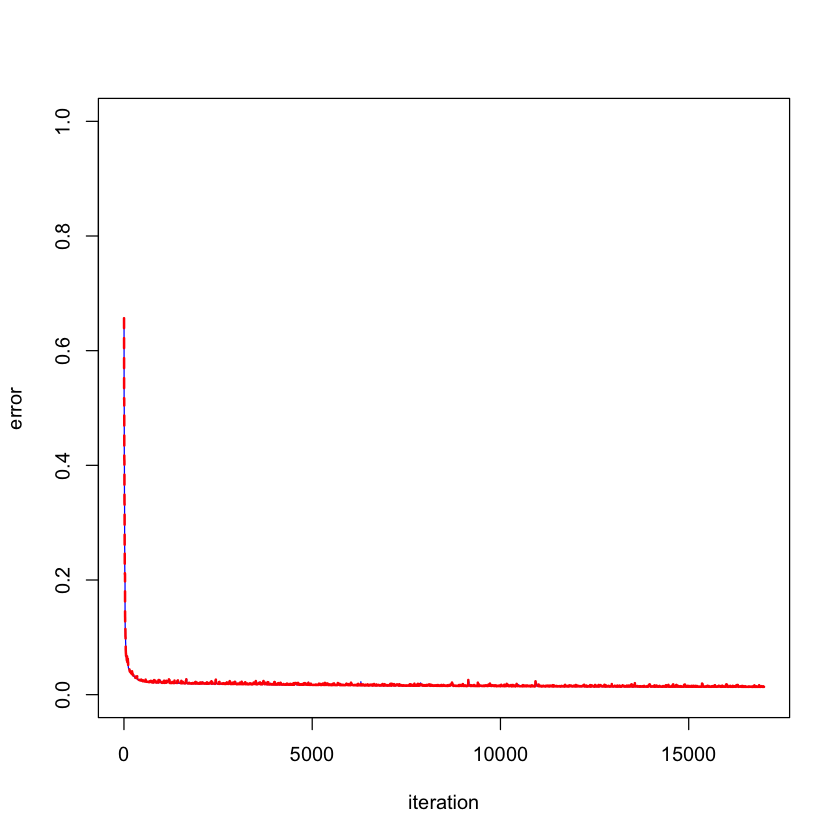

In [40]:
# playing with the SGD part
play_with_sgd()
options(warn = -1)

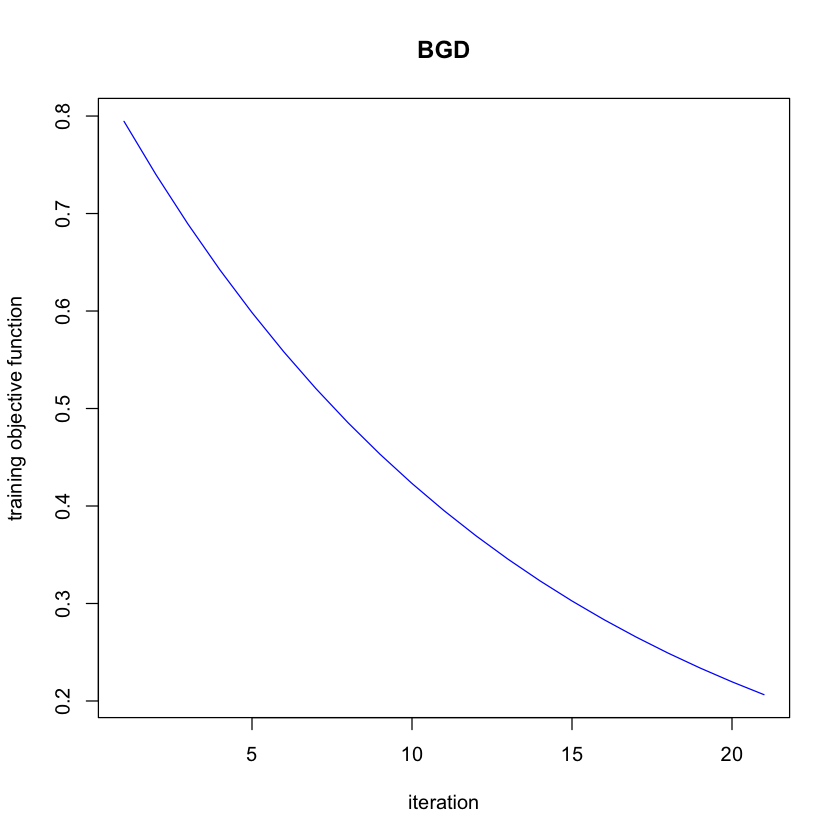

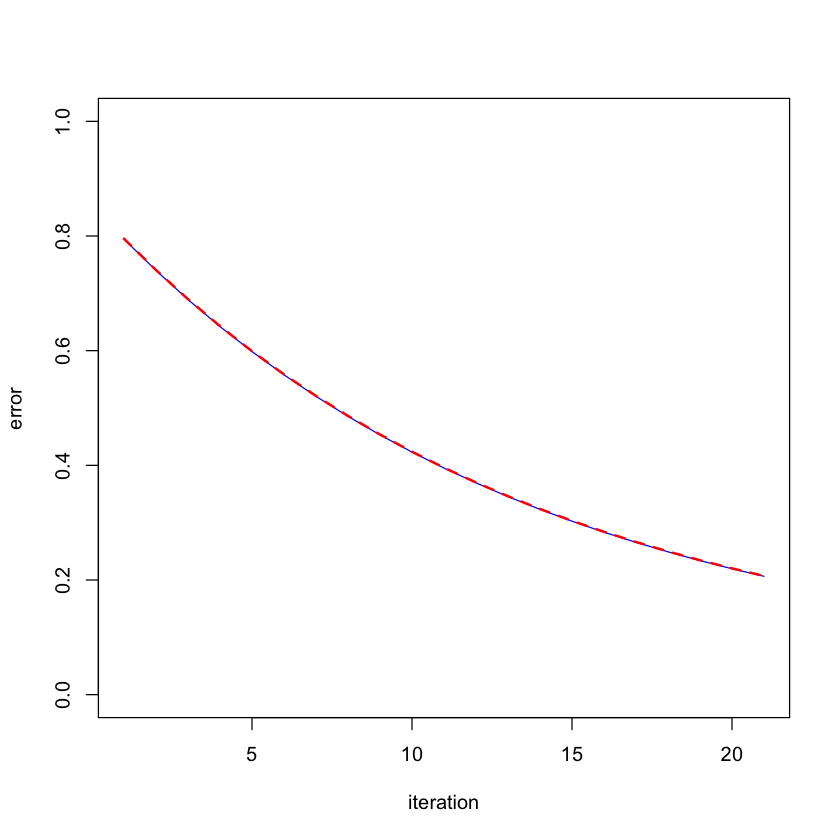

In [47]:
# playing with the BGD part
play_with_bgd()
options(warn = -1)

### Q6-3-d Explain your observation based on the errors plot you generated in Part c. Particularly, discuss the convergence speed and the fluctuations you see in the error trends.

The first plot of SGD shows that the model fastly converges at the beginning, and as the number of iterations increases, the model slowly converges. The error trend similarity with convergence trend, the error decreases with the increasing number of iterations, fast after first, big after first. As the number of iterations increases, the error decreases. For BGD plots, the downward trend of convergence speed and errror are flatter than the trends of SGD.